In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.globals import ThemeType
from pyecharts.charts import Bar, Pie, Line

plt.rcParams['font.sans-serif']=['Microsoft Yahei']  # Fix Chinese unrecognized issue 
plt.rcParams['axes.unicode_minus']=False # Fix Minus Sign unrecognized issue

In [2]:
# CSV文件来自Amazon后台“数据报告/库存和销售报告/亚马逊物流买家退货”导出文件。
workdf = pd.read_csv('data/amz_returns_180101_190615.csv')

# 添加款式字段
model = []
for item in workdf['sku']:
    model.append(item[0:6])
workdf['model'] = model

# 添加尺码字段
size = []
for item in workdf['sku']:
    size.append(item[-2:]+'码')
workdf['size'] = size

# 添加性别字段
gender = []
for item in workdf['sku']:
    gid = int(item[3:4])
    if gid == 5:
        gender.append('女款棉拖')
    elif gid == 7:
        gender.append('女款')
    elif gid == 8:
        gender.append('男款')
    elif gid == 9:
        gender.append('童款')
    else:
        gender.append('未知')
    
workdf['gender'] = gender

workdf.head()

,return-date,sku,quantity,fulfillment-center-id,detailed-disposition,reason,status,customer-comments,model,size,gender
0,2019-06-16T03:36:20+00:00,HM0722-H-39,1,SDF9,SELLABLE,APPAREL_TOO_SMALL,Unit returned to inventory,NaN,HM0722,39码,女款
1,2019-06-16T02:26:35+00:00,HM0731-Z-40,1,MIA7,SELLABLE,APPAREL_STYLE,Unit returned to inventory,NaN,HM0731,40码,女款
2,2019-06-15T21:55:00+00:00,HM0731-Y-37,1,RIC9,SELLABLE,APPAREL_TOO_SMALL,Unit returned to inventory,NaN,HM0731,37码,女款
3,2019-06-15T05:28:25+00:00,HM0731-Z-42,1,LAS2,SELLABLE,APPAREL_STYLE,Unit returned to inventory,NaN,HM0731,42码,女款
4,2019-06-15T04:32:52+00:00,HM0742-2238,1,BUF9,SELLABLE,APPAREL_TOO_SMALL,Unit returned to inventory,NaN,HM0742,38码,女款


In [3]:
# 以下语句将所有不重复的顾客退货留言输出保存到CSV文件。
# workdf['customer-comments'].dropna().drop_duplicates().to_csv('output/amz_returns_customer_comments.csv', header=['customer-comments'])

# 退货情况分析图表

In [4]:
#help(Bar().set_global_opts())

groupdf1 = workdf[['reason', 'quantity']].groupby('reason')
gdf1 = pd.DataFrame({
    '退货原因':list(groupdf1.groups.keys()),
    '数量':list(groupdf1['quantity'].sum().to_list()),
})

sorted_gdf1 = gdf1.sort_values('数量')
sorted_gdf1.tail()

,退货原因,数量
20,UNWANTED_ITEM,82
6,MISORDERED,94
1,APPAREL_TOO_LARGE,188
0,APPAREL_STYLE,260
2,APPAREL_TOO_SMALL,470


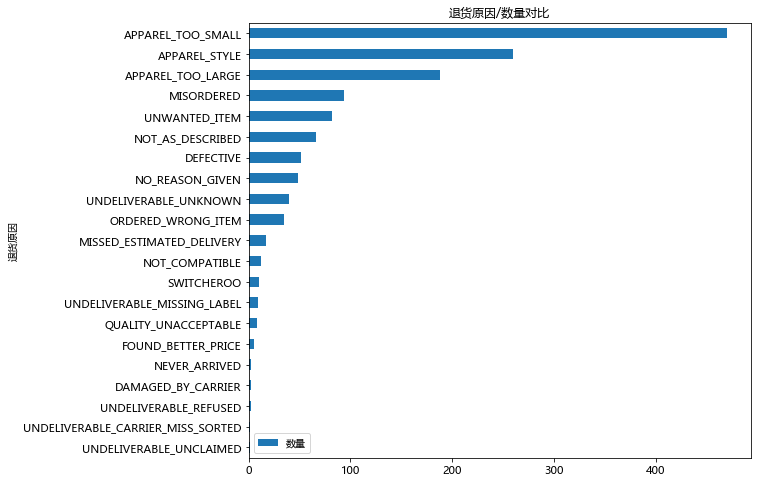

In [5]:
sorted_gdf1.plot(
    kind='barh', 
    x = '退货原因',
    y = '数量',
    grid = False,
    table = False,
    title='退货原因/数量对比', 
    figsize=(9, 8),
    fontsize=11
)

In [6]:
returns_piedata = [['其他', int(sorted_gdf1['数量'][:-10].sum())]]
for x, y in zip(sorted_gdf1['退货原因'][-10:].to_list(), sorted_gdf1['数量'][-10:].to_list()):
    returns_piedata.append([x, y])
returns_piedata = returns_piedata[::-1]
returns_piedata

[['APPAREL_TOO_SMALL', 470],
 ['APPAREL_STYLE', 260],
 ['APPAREL_TOO_LARGE', 188],
 ['MISORDERED', 94],
 ['UNWANTED_ITEM', 82],
 ['NOT_AS_DESCRIBED', 66],
 ['DEFECTIVE', 51],
 ['NO_REASON_GIVEN', 48],
 ['UNDELIVERABLE_UNKNOWN', 40],
 ['ORDERED_WRONG_ITEM', 35],
 ['其他', 69]]

pyecharts **ThemeType**:

'BUILTIN_THEMES', 'CHALK', 'DARK', 'ESSOS', 'INFOGRAPHIC', 'LIGHT', 

'MACARONS', 'PURPLE_PASSION', 'ROMA', 'ROMANTIC', 'SHINE', 'VINTAGE', 

'WALDEN', 'WESTEROS', 'WHITE', 'WONDERLAND'

In [7]:
pie1 = (
    Pie(init_opts = opts.InitOpts())
    .add("退货数量", returns_piedata, radius=['25%', '60%'])
    .set_global_opts(title_opts = opts.TitleOpts(
        title="FBA TOP 10 退货原因/数量占比 (2018年1月-2019年6月)",
        pos_left='center', pos_top="bottom"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}双，占比：{d}%"))
)
pie1.render_notebook()

In [8]:
groupdf2 = workdf[['model', 'quantity']].groupby('model')
gdf2 = pd.DataFrame({
    '款式':list(groupdf2.groups.keys()),
    '数量':list(groupdf2['quantity'].sum().to_list()),
})

sorted_gdf2 = gdf2.sort_values('数量')
sorted_gdf2[::-1].head(10)

,款式,数量
1,HM0701,371
16,HM0731,301
9,HM0722,289
19,HM0738,58
11,HM0724,55
18,HM0737,39
12,HM0725,38
26,HM0801,35
4,HM0709,32
22,HM0742,26


In [9]:
#help(Bar().set_series_opts())

In [10]:
bar1 = (
    Bar(init_opts = opts.InitOpts(height="548px"))
    .add_xaxis(sorted_gdf2['款式'].to_list())
    .add_yaxis('款式', sorted_gdf2['数量'].to_list())
    .reversal_axis()
    .set_global_opts(
        legend_opts = opts.LegendOpts(pos_left="center", pos_top="bottom"),
        title_opts = opts.TitleOpts(title="FBA TOP 10 退货款式/数量对比 (2018年1月-2019年6月)"),
        yaxis_opts = opts.AxisOpts(axislabel_opts = opts.LabelOpts(font_size=10))
    )
    .set_series_opts(
        label_opts = opts.LabelOpts(position="right")
    )
)
bar1.render_notebook()

In [11]:
# 统计各类拖鞋的退货数量
workdf[['gender', 'quantity']].groupby('gender').sum()

,quantity
gender,
女款,1326
女款棉拖,8
男款,60
童款,9


In [12]:
# 以下两条语句返回结果相同， 均得到尺码分类的退货数量总和。
#groupdf3 = workdf[(workdf.gender=='Female')].groupby('size').sum()
groupdf3 = workdf[['gender', 'size', 'quantity']].query('gender=="女款"').groupby('size')
size_returns = [list(x) for x in zip(list(groupdf3.groups.keys()), groupdf3['quantity'].sum().to_list())]

In [13]:
pie2 = (
    Pie(init_opts = opts.InitOpts(theme=ThemeType.CHALK))
    .add("退货数量", size_returns, radius=['25%', '60%'])
    .set_global_opts(title_opts = opts.TitleOpts(
        title="FBA TOP 10 女款各尺码退货数量占比 (2018年1月-2019年6月)",
        pos_left='center', pos_top="bottom"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}双，占比：{d}%"))
)
pie2.render_notebook()

[返回目录](amz_returns_catalog.ipynb)